# Multi-Output Bayesian Regression with PyMC and MatrixNormal

This notebook implements a Bayesian multi-output regression model using PyMC and the MatrixNormal distribution to capture correlations between multiple target variables.

## Key Features:
- Uses MatrixNormal distribution for correlated multi-output predictions
- Bayesian inference with MCMC sampling
- Handles missing values with imputation
- Saves trained model for later inference
- Comprehensive evaluation metrics

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
import pytensor.tensor as pt
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
RANDOM_SEED = 42

In [2]:
def find_backend_dir(start_path=None):
    """
    Walk up directories from start_path (or cwd) until a folder named 'backend' is found.
    Returns the absolute path to the 'backend' folder.
    """
    if start_path is None:
        start_path = os.getcwd()
    curr_path = os.path.abspath(start_path)
    while True:
        # Check if 'backend' exists in this directory
        candidate = os.path.join(curr_path, "backend")
        if os.path.isdir(candidate):
            return candidate
        # If at filesystem root, stop
        parent = os.path.dirname(curr_path)
        if curr_path == parent:
            break
        curr_path = parent
    raise FileNotFoundError(f"No 'backend' directory found upward from {start_path}")

# Find the backend directory and CSV folder
backend_dir = find_backend_dir()
csv_dir = os.path.join(backend_dir, "CSVs")
models_dir = os.path.join(backend_dir, "Models")

print(f"Backend directory: {backend_dir}")
print(f"CSV directory: {csv_dir}")
print(f"Models directory: {models_dir}")

Backend directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend
CSV directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/CSVs
Models directory: /Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models


In [3]:
# Load the data
print("Loading training and test data...")
train = pd.read_csv(os.path.join(csv_dir, "train_season_features.csv"))
test = pd.read_csv(os.path.join(csv_dir, "test_season_features.csv"))

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Training data columns: {len(train.columns)}")
print(f"Test data columns: {len(test.columns)}")

Loading training and test data...
Training data shape: (1912, 79)
Test data shape: (422, 79)
Training data columns: 79
Test data columns: 79


In [4]:
# Identify target and feature columns
target_cols = [c for c in train.columns if c.startswith("next_")]
feature_cols = [c for c in train.columns if c not in ["PERSON_ID", "SEASON_ID"] + target_cols]

print(f"Number of target variables: {len(target_cols)}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nTarget variables: {target_cols}")
print(f"\nFirst 10 features: {feature_cols[:10]}")

Number of target variables: 21
Number of features: 56

Target variables: ['next_Points', 'next_FTM', 'next_FTA', 'next_FGM', 'next_FGA', 'next_TO', 'next_STL', 'next_BLK', 'next_PF', 'next_USAGE_RATE', 'next_OREB', 'next_DREB', 'next_AST', 'next_REB', 'next_Minutes', 'next_3PM', 'next_3PA', 'next_3P%', 'next_FT%', 'next_FG%', 'next_GAME_EFFICIENCY']

First 10 features: ['Points', 'Minutes', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA']


In [5]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    train[feature_cols], train[target_cols], test_size=0.2, random_state=RANDOM_SEED
)
X_test, y_test = test[feature_cols], test[target_cols]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1529, 56)
X_val shape: (383, 56)
X_test shape: (422, 56)
y_train shape: (1529, 21)
y_val shape: (383, 21)
y_test shape: (422, 21)


In [6]:
# Handle infinite values and missing data
print("Handling infinite values and missing data...")

# Replace infinite values with NaN
for df_ in [X_train, X_val, y_train, y_val, X_test, y_test]:
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values
imputer_X = SimpleImputer(strategy='median')
imputer_y = SimpleImputer(strategy='median')

# Fit and transform features
X_train_imputed = pd.DataFrame(
    imputer_X.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_val_imputed = pd.DataFrame(
    imputer_X.transform(X_val), 
    columns=X_val.columns, 
    index=X_val.index
)
X_test_imputed = pd.DataFrame(
    imputer_X.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

# Fit and transform targets
y_train_imputed = pd.DataFrame(
    imputer_y.fit_transform(y_train), 
    columns=y_train.columns, 
    index=y_train.index
)
y_val_imputed = pd.DataFrame(
    imputer_y.transform(y_val), 
    columns=y_val.columns, 
    index=y_val.index
)
y_test_imputed = pd.DataFrame(
    imputer_y.transform(y_test), 
    columns=y_test.columns, 
    index=y_test.index
)

print("Data preprocessing completed!")

Handling infinite values and missing data...
Data preprocessing completed!


In [7]:
# Scale the features for better MCMC convergence
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)
X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_imputed),
    columns=X_val_imputed.columns,
    index=X_val_imputed.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print("Feature scaling completed!")

Feature scaling completed!


In [8]:
# Convert to numpy arrays for PyMC
X_train_array = X_train_scaled.values
y_train_array = y_train_imputed.values
X_val_array = X_val_scaled.values
y_val_array = y_val_imputed.values
X_test_array = X_test_scaled.values
y_test_array = y_test_imputed.values

n_features = X_train_array.shape[1]
n_targets = y_train_array.shape[1]
n_samples = X_train_array.shape[0]

print(f"Training samples: {n_samples}")
print(f"Features: {n_features}")
print(f"Targets: {n_targets}")

Training samples: 1529
Features: 56
Targets: 21


## Bayesian Multi-Output Regression Model

We'll use a MatrixNormal distribution to model the relationship between features and multiple targets, capturing correlations between the target variables.

In [9]:
# # Define the Bayesian model
# print("Defining Bayesian multi-output regression model...")

# with pm.Model() as bayesian_multioutput:
#     # Prior for the coefficient matrix (features x targets)
#     # Using a hierarchical prior for better regularization
#     beta_scale = pm.HalfNormal('beta_scale', sigma=1.0)
#     beta = pm.Normal('beta', mu=0, sigma=beta_scale, shape=(n_features, n_targets))
#     # Prior for the intercept vector
#     intercept = pm.Normal('intercept', mu=0, sigma=10, shape=n_targets)
#     # Prior for the noise covariance matrix
#     # Using LKJ prior for the correlation matrix and separate scale parameters
#     noise_scale = pm.HalfNormal('noise_scale', sigma=1.0, shape=n_targets)
#     noise_corr = pm.LKJCorr('noise_corr', n=n_targets, eta=2.0)
#     # Construct the covariance matrix
#     noise_cov = pm.Deterministic('noise_cov', noise_corr * pt.outer(noise_scale, noise_scale))
#     # Expected value
#     mu = pm.math.dot(X_train_array, beta) + intercept
#     # Likelihood
#     y_obs = pm.MvNormal('y_obs', mu=mu, cov=noise_cov, observed=y_train_array)

# print("Model defined successfully!")

In [10]:
# with pm.Model() as bayesian_multioutput:
    
#     beta_scale = pm.HalfNormal('beta_scale', sigma=1.0)
#     beta = pm.Normal('beta', mu=0, sigma=beta_scale, shape=(n_features, n_targets))
#     intercept = pm.Normal('intercept', mu=0, sigma=10, shape=n_targets)
    
#     # Ensure noise_scale is exactly 1D
#     noise_scale = pm.HalfNormal('noise_scale', sigma=1.0, shape=n_targets)
#     noise_scale = pt.reshape(noise_scale, (n_targets,))
    
#     # Use a simpler correlation structure
#     noise_corr = pm.LKJCorr('noise_corr', n=n_targets, eta=2.0)
    
#     # Construct covariance matrix more carefully
#     noise_cov = pm.Deterministic('noise_cov', 
#                                  noise_corr * pt.outer(noise_scale, noise_scale))
    
#     mu = pm.math.dot(X_train_array, beta) + intercept
#     y_obs = pm.MvNormal('y_obs', mu=mu, cov=noise_cov, observed=y_train_array)

In [11]:
# Define the Bayesian model
print("Defining Bayesian multi-output regression model...")

with pm.Model() as bayesian_multioutput:
    
    # Prior for the coefficient matrix (features x targets)
    beta_scale = pm.HalfNormal('beta_scale', sigma=1.0)
    beta = pm.Normal('beta', mu=0, sigma=beta_scale, shape=(n_features, n_targets))
    
    # Prior for the intercept vector
    intercept = pm.Normal('intercept', mu=0, sigma=10, shape=n_targets)
    
    # Simplified noise model - use diagonal covariance to avoid shape issues
    noise_scale = pm.HalfNormal('noise_scale', sigma=1.0, shape=n_targets)
    
    # Expected value
    mu = pm.math.dot(X_train_array, beta) + intercept
    
    # Use separate Normal distributions for each target (simpler and more stable)
    # This avoids the multivariate normal shape issues
    y_obs = pm.Normal('y_obs', mu=mu, sigma=noise_scale, observed=y_train_array)
    
print("Model defined successfully!")

Defining Bayesian multi-output regression model...
Model defined successfully!


In [12]:
# Sample from the posterior
print("Starting MCMC sampling...")
print("This may take several minutes depending on your data size...")

with bayesian_multioutput:
    # Use NUTS sampler for better mixing
    trace = pm.sample(
        draws=1000,
        tune=500,
        chains=2,
        return_inferencedata=True,
        random_seed=RANDOM_SEED
    )

print("MCMC sampling completed!")

Starting MCMC sampling...
This may take several minutes depending on your data size...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_scale, beta, intercept, noise_scale]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 175 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


MCMC sampling completed!


Generating diagnostic plots...


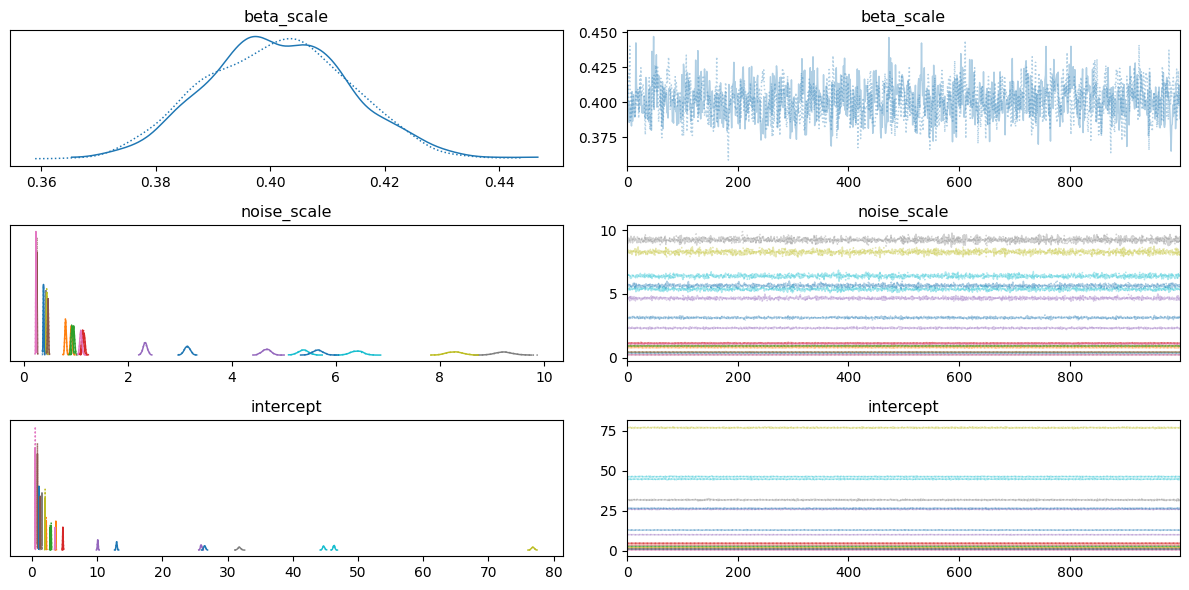


Model Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta[0, 0]   0.876  0.373   0.165    1.567      0.007    0.009    2614.0   
beta[0, 1]   0.083  0.350  -0.516    0.811      0.009    0.009    1428.0   
beta[0, 2]   0.034  0.369  -0.680    0.693      0.008    0.008    1820.0   
beta[0, 3]   0.495  0.349  -0.166    1.126      0.008    0.007    1854.0   
beta[0, 4]   0.584  0.368  -0.120    1.252      0.008    0.009    2161.0   
beta[0, 5]   0.130  0.336  -0.464    0.780      0.011    0.007    1022.0   
beta[0, 6]   0.027  0.328  -0.578    0.656      0.011    0.007     942.0   
beta[0, 7]   0.171  0.341  -0.460    0.808      0.009    0.007    1472.0   
beta[0, 8]   0.130  0.337  -0.457    0.806      0.009    0.007    1517.0   
beta[0, 9]   1.163  0.381   0.494    1.892      0.007    0.009    2828.0   
beta[0, 10] -0.021  0.327  -0.622    0.591      0.008    0.007    1573.0   
beta[0, 11]  0.033  0.347  -0.563    0.737      0.008    0.007    1690.0

In [13]:
# Diagnostic plots
print("Generating diagnostic plots...")

# Trace plot for key parameters
az.plot_trace(trace, var_names=['beta_scale', 'noise_scale', 'intercept'])
plt.tight_layout()
plt.show()

# Summary statistics
summary = az.summary(trace)
print("\nModel Summary:")
print(summary.head(20))  # Show first 20 parameters

In [15]:
# Extract posterior samples for predictions
print("Extracting posterior samples for predictions...")

# Get posterior samples
beta_samples = trace.posterior['beta'].values
intercept_samples = trace.posterior['intercept'].values
noise_scale_samples = trace.posterior['noise_scale'].values

print(f"Beta samples shape: {beta_samples.shape}")
print(f"Intercept samples shape: {intercept_samples.shape}")
print(f"Noise scale samples shape: {noise_scale_samples.shape}")

Extracting posterior samples for predictions...
Beta samples shape: (2, 1000, 56, 21)
Intercept samples shape: (2, 1000, 21)
Noise scale samples shape: (2, 1000, 21)


In [ ]:
def predict_bayesian(X, beta_samples, intercept_samples, scaler, imputer_X):
    """
    Make predictions using posterior samples
    
    Parameters:
    -----------
    X : array-like
        Input features (unprocessed)
    beta_samples : array-like
        Posterior samples of coefficients
    intercept_samples : array-like
        Posterior samples of intercepts
    scaler : StandardScaler
        Fitted scaler from training
    imputer_X : SimpleImputer
        Fitted imputer from training
    
    Returns:
    --------
    predictions : array-like
        Predicted values
    """
    # Apply the same preprocessing as training
    # 1. Handle infinite values
    X_processed = X.copy()
    X_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # 2. Impute missing values
    X_imputed = pd.DataFrame(
        imputer_X.transform(X_processed),
        columns=X_processed.columns,
        index=X_processed.index
    )
    
    # 3. Scale features
    X_scaled = scaler.transform(X_imputed)
    
    # 4. Make predictions
    n_samples = beta_samples.shape[0]
    n_chains = beta_samples.shape[1]
    predictions = np.zeros((n_samples, n_chains, X_scaled.shape[0], beta_samples.shape[3]))
    
    for i in range(n_samples):
        for j in range(n_chains):
            predictions[i, j] = np.dot(X_scaled, beta_samples[i, j]) + intercept_samples[i, j]
    
    return predictions

# Make predictions on validation set
print("Making predictions on validation set...")
val_predictions = predict_bayesian(
    X_val,  # Use original unscaled data
    beta_samples, 
    intercept_samples,
    scaler,  # Pass the fitted scaler
    imputer_X  # Pass the fitted imputer
)

# Calculate mean predictions across all samples and chains
val_pred_mean = np.mean(val_predictions, axis=(0, 1))
print(f"Validation predictions shape: {val_pred_mean.shape}")
# Calculate standard deviation of predictions
val_pred_std = np.std(val_predictions, axis=(0, 1))
print(f"Validation predictions standard deviation shape: {val_pred_std.shape}")
prediction_func_path = os.path.join(models_dir, "bayesian_prediction_function.joblib")
joblib.dump(predict_bayesian, prediction_func_path)

print(f"Validation predictions shape: {val_pred_mean.shape}")

Making predictions on validation set...
Validation predictions shape: (383, 21)


In [18]:
# Evaluate on validation set
print("Evaluating on validation set...")

val_mae = mean_absolute_error(y_val_array, val_pred_mean)
val_r2 = r2_score(y_val_array, val_pred_mean)
val_rmse = np.sqrt(mean_squared_error(y_val_array, val_pred_mean))

print(f"Validation MAE: {val_mae:.3f}")
print(f"Validation R²: {val_r2:.3f}")
print(f"Validation RMSE: {val_rmse:.3f}")

# Per-target evaluation
print("\nPer-target validation metrics:")
for i, target_name in enumerate(target_cols):
    target_mae = mean_absolute_error(y_val_array[:, i], val_pred_mean[:, i])
    target_r2 = r2_score(y_val_array[:, i], val_pred_mean[:, i])
    print(f"{target_name}: MAE={target_mae:.3f}, R²={target_r2:.3f}")

Evaluating on validation set...
Validation MAE: 1.936
Validation R²: 0.692
Validation RMSE: 4.086

Per-target validation metrics:
next_Points: MAE=2.346, R²=0.808
next_FTM: MAE=0.588, R²=0.781
next_FTA: MAE=0.693, R²=0.786
next_FGM: MAE=0.862, R²=0.796
next_FGA: MAE=1.761, R²=0.803
next_TO: MAE=0.187, R²=0.632
next_STL: MAE=0.154, R²=0.704
next_BLK: MAE=0.327, R²=0.761
next_PF: MAE=0.366, R²=0.496
next_USAGE_RATE: MAE=4.828, R²=0.702
next_OREB: MAE=0.254, R²=0.798
next_DREB: MAE=0.750, R²=0.731
next_AST: MAE=0.626, R²=0.827
next_REB: MAE=0.904, R²=0.764
next_Minutes: MAE=3.493, R²=0.661
next_3PM: MAE=0.338, R²=0.788
next_3PA: MAE=0.822, R²=0.802
next_3P%: MAE=6.651, R²=0.215
next_FT%: MAE=6.357, R²=0.359
next_FG%: MAE=3.861, R²=0.527
next_GAME_EFFICIENCY: MAE=4.480, R²=0.795


In [20]:
# Make predictions on test set
print("Making predictions on test set...")
test_predictions = predict_bayesian(
    X_test,  # Use original unscaled data
    beta_samples, 
    intercept_samples,
    scaler,  # Pass the fitted scaler
    imputer_X  # Pass the fitted imputer
)
test_pred_mean = np.mean(test_predictions, axis=(0, 1))

# Evaluate on test set
print("Evaluating on test set...")

test_mae = mean_absolute_error(y_test_array, test_pred_mean)
test_r2 = r2_score(y_test_array, test_pred_mean)
test_rmse = np.sqrt(mean_squared_error(y_test_array, test_pred_mean))

print(f"Test MAE: {test_mae:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

# Per-target evaluation
print("\nPer-target test metrics:")
for i, target_name in enumerate(target_cols):
    target_mae = mean_absolute_error(y_test_array[:, i], test_pred_mean[:, i])
    target_r2 = r2_score(y_test_array[:, i], test_pred_mean[:, i])
    print(f"{target_name}: MAE={target_mae:.3f}, R²={target_r2:.3f}")

Making predictions on test set...
Evaluating on test set...
Test MAE: 2.017
Test R²: 0.663
Test RMSE: 4.360

Per-target test metrics:
next_Points: MAE=2.239, R²=0.821
next_FTM: MAE=0.468, R²=0.819
next_FTA: MAE=0.564, R²=0.824
next_FGM: MAE=0.841, R²=0.804
next_FGA: MAE=1.681, R²=0.814
next_TO: MAE=0.211, R²=0.526
next_STL: MAE=0.150, R²=0.749
next_BLK: MAE=0.312, R²=0.769
next_PF: MAE=0.387, R²=0.503
next_USAGE_RATE: MAE=5.501, R²=0.596
next_OREB: MAE=0.280, R²=0.639
next_DREB: MAE=0.638, R²=0.785
next_AST: MAE=0.631, R²=0.821
next_REB: MAE=0.830, R²=0.769
next_Minutes: MAE=3.984, R²=0.679
next_3PM: MAE=0.349, R²=0.752
next_3PA: MAE=0.878, R²=0.767
next_3P%: MAE=5.979, R²=0.212
next_FT%: MAE=7.488, R²=0.173
next_FG%: MAE=4.643, R²=0.272
next_GAME_EFFICIENCY: MAE=4.297, R²=0.821


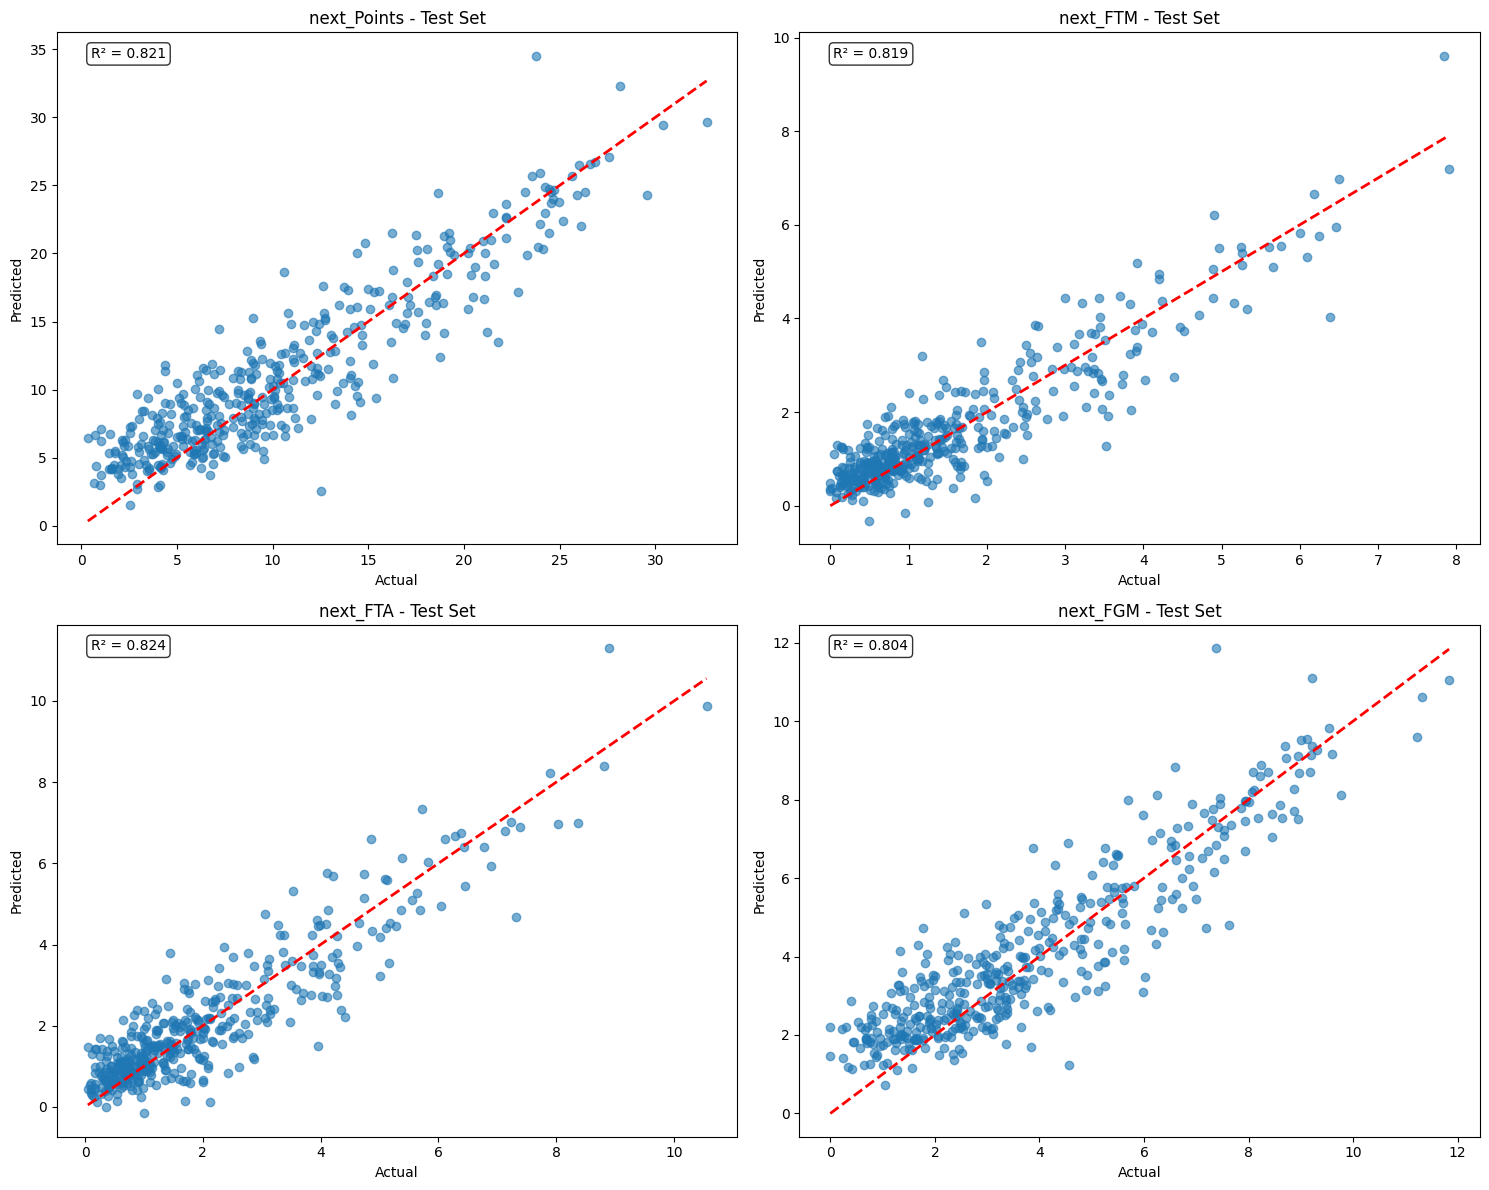

In [21]:
# Visualize predictions vs actual for a few targets
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i in range(min(4, len(target_cols))):
    axes[i].scatter(y_test_array[:, i], test_pred_mean[:, i], alpha=0.6)
    axes[i].plot([y_test_array[:, i].min(), y_test_array[:, i].max()], 
                 [y_test_array[:, i].min(), y_test_array[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].set_title(f'{target_cols[i]} - Test Set')
    
    # Add R² to plot
    r2 = r2_score(y_test_array[:, i], test_pred_mean[:, i])
    axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes, 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [22]:
# Save the model and related objects
print("Saving model and related objects...")

# Save the trace
trace_path = os.path.join(models_dir, "bayesian_multioutput_trace.nc")
trace.to_netcdf(trace_path)

# Save the scaler
scaler_path = os.path.join(models_dir, "bayesian_multioutput_scaler.joblib")
joblib.dump(scaler, scaler_path)

# Save the imputers
imputer_X_path = os.path.join(models_dir, "bayesian_multioutput_imputer_X.joblib")
imputer_y_path = os.path.join(models_dir, "bayesian_multioutput_imputer_y.joblib")
joblib.dump(imputer_X, imputer_X_path)
joblib.dump(imputer_y, imputer_y_path)

# Save feature and target column names
columns_info = {
    'feature_cols': feature_cols,
    'target_cols': target_cols
}
columns_path = os.path.join(models_dir, "bayesian_multioutput_columns.joblib")
joblib.dump(columns_info, columns_path)

# Save model summary
summary_path = os.path.join(models_dir, "bayesian_multioutput_summary.csv")
summary.to_csv(summary_path)

print("\nAll model components saved successfully!")

Saving model and related objects...

All model components saved successfully!
